# SVM Lab
在本Lab中，你将学会训练并使用一个SVM分类器来对数据进行分类。在完成本Lab后，你将会对SVM的dual form以及其训练算法有一个更深入的理解。请按顺序依次完成以下任务。


## 准备工作

### 环境准备

请确保完成以下依赖包的安装，并且通过下面代码来导入与验证。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm


np.random.seed(0)

### 数据集准备

我们将使用以下zipper数据集来训练SVM分类器，并观察训练效果。

该数据集包含两个特征，以及一个标签y，其外观像是一个拉链。我们将使用SVM分类器来对数据集进行分类，预测两种类别中间的三角函数分界线。

请运行下面的代码来加载并可视化zipper dataset。

In [3]:
from dataset_generator import zipper_2D_dataset

n_pos = 100
n_neg = 100

x_train, y_train = zipper_2D_dataset(n_pos, n_neg, scope=4.0)
x_test, y_test = zipper_2D_dataset(50, 50, scope=5.5) # Test data is slightly out-of-distribution

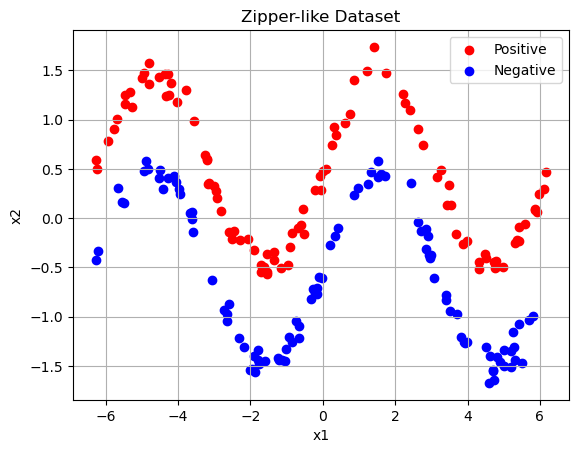

In [4]:
from vis_utils import visualize_2D_dataset

visualize_2D_dataset(x_train, y_train)

## Part 1: Support Vector Machine (10 pts)

在本部分，你将学习并完成SVM dual form的编写与训练。

在运行该部分代码前，请首先：

1. **补全kernels.py中三个kernel的代码；** (请首先阅读Base_kernel类的注释)

2. **补全SVM.py中SVM的predict函数；**

In [19]:
from SVM import SVM
from kernels import Linear_kernel, Polynomial_kernel, RBF_kernel

kernel_fn = Linear_kernel()
svm = SVM(kernel_fn=kernel_fn)

## Part 2: Simplified SMO (10 pts)

为了对SVM进行训练，我们需要对以下目标函数进行优化：




\begin{aligned}
 \max_{\alpha}&\ \  W(\alpha) = \sum_{i=1}^{m} \alpha_i - \frac{1}{2} \sum_{i=1}^{m} \sum_{j=1}^{m} y^{(i)} y^{(j)} \alpha_i \alpha_j \kappa ( x^{(i)}, x^{(j)})  \\
 \text{subject to}& \ \ 0 \leq \alpha_i \leq C, \quad i = 1, \ldots, m \\
&\ \ \sum_{i=1}^{m} \alpha_i y^{(i)} = 0
\end{aligned}


一种常用的优化SVM的算法叫做SMO，全称是序列最小优化(Sequential Minimal Optimization)。它是由Platt于1998年提出的，用于高效地解决上述的二次规划问题。

SMO采取的策略是：多次迭代优化，每一次优化时仅优化两个变量，而固定其他变量。选择两个变量的原因是因为我们有一个线性的等式约束，这使得给定一个变量，另一个变量就可以由它确定。这样，问题就简化为本质上只有一个变量的优化问题，它可以通过解析方法得到解决。

SMO算法的工作流程如下：

1. 采用heuristic选择两个待优化的变量：一种常见的方法是选择违反KKT条件最严重的变量作为第一个变量，进一步选择使得目标函数值改变最大的变量作为第二个变量。

2. 固定其他变量，对这两个变量通过解析方法进行优化。（本质上是一个2 order polynomial的优化问题）

3. 检查是否所有变量都满足KKT条件：如果满足，则算法停止；否则，返回到第一步。

在实际应用中，SMO算法通过反复地选择和优化两个变量，直到整个数据集都满足KKT条件或满足一定的停止标准。由于每次都是解决一个简化的问题，SMO算法通常可以很快地收敛到最优解。



在本部分，我们将编写一种**简化版的SMO算法**，称为Simplified SMO。其简化之处主要在于上述工作流程中的第一步，即如何选取这两个待优化的变量上。在Simplified SMO中，我们采用的策略是：

1. 首先遍历所有的变量，直到找到第一个违反KKT条件的变量 $\alpha_i$，将其作为第一个待优化的变量；

2. 从所有其他变量中随机选择一个变量 $\alpha_j$ 作为第二个待优化的变量。

3. 在完成针对于这两个变量的优化后，从 $\alpha_i$ 开始继续遍历。若 $\alpha_i$ 已是最后一个变量，则从第一个变量开始重新遍历。

相比于SMO，Simplified SMO无法保证总是能优化到全局最优点，因为其无法保证对每一对变量都进行优化。然而，其能保证在绝大多数情况下均能收敛到不错的解。（注意，由于你每一次都是在做优化，因此你的objective function值应该总是在不断变小的。）

**请你来补全SSMO.py中SSMO_optimizer.fit中的循环代码。**

注意：

1. judge_violoate_KKT(), compute_E(), compute_eta(), compute_new_aj() when eta < 0, compute_b(), update_SVM()等已给出，你可以直接调用，请首先完成这些函数及其注释的阅读。

2. **compute_L_H(), compute_new_aj() when eta > 0, compute_new_ai 三个函数的代码未给出，需要你根据TODO处的要求来补全。**



采用Simplified SMO算法，我们可以对SVM进行训练。请运行下面的代码进行训练。若你的代码正确，你将会看到每一个pass的loss均在单调下降。

In [20]:
from SSMO import SSMO_optimizer
C = 1.0
max_passes = 1000

optimizer = SSMO_optimizer(C=C)
optimizer.fit(svm, x_train, y_train, max_passes=max_passes, verbose=True)


0it [00:00, ?it/s]
loss: -4.2493: : 0it [00:00, ?it/s]
loss: -12.2517: : 1it [00:00, 41.23it/s]
loss: -34.4199: : 2it [00:00, 51.53it/s]
loss: -46.0579: : 3it [00:00, 56.97it/s]
loss: -54.1057: : 4it [00:00, 56.85it/s]
loss: -66.4194: : 5it [00:00, 58.75it/s]
loss: -74.2471: : 6it [00:00, 60.03it/s]
loss: -74.2471: : 7it [00:00, 69.22it/s]
loss: -80.4641: : 7it [00:00, 69.22it/s]
loss: -85.5254: : 8it [00:00, 69.22it/s]
loss: -87.7433: : 9it [00:00, 69.22it/s]
loss: -90.3754: : 10it [00:00, 69.22it/s]
loss: -92.2908: : 11it [00:00, 69.22it/s]
loss: -94.6286: : 12it [00:00, 69.22it/s]
loss: -95.4589: : 13it [00:00, 69.22it/s]
loss: -98.2778: : 14it [00:00, 69.22it/s]
loss: -98.2778: : 15it [00:00, 74.75it/s]
loss: -98.7658: : 15it [00:00, 74.75it/s]
loss: -99.2765: : 16it [00:00, 74.75it/s]
loss: -100.2598: : 17it [00:00, 74.75it/s]
loss: -100.8163: : 18it [00:00, 74.75it/s]
loss: -101.2779: : 19it [00:00, 74.75it/s]
loss: -101.9822: : 20it [00:00, 74.75it/s]
loss: -102.1416: : 21it [0

loss: -106.2451: : 161it [00:01, 142.62it/s]
loss: -106.2457: : 162it [00:01, 142.62it/s]
loss: -106.2466: : 163it [00:01, 142.62it/s]
loss: -106.2475: : 164it [00:01, 142.62it/s]
loss: -106.2481: : 165it [00:01, 142.62it/s]
loss: -106.2482: : 166it [00:01, 142.62it/s]
loss: -106.2487: : 167it [00:01, 142.62it/s]
loss: -106.2493: : 168it [00:01, 142.62it/s]
loss: -106.2502: : 169it [00:01, 142.62it/s]
loss: -106.2502: : 170it [00:01, 142.62it/s]
loss: -106.2505: : 171it [00:01, 142.62it/s]
loss: -106.2508: : 172it [00:01, 142.62it/s]
loss: -106.2508: : 173it [00:01, 142.95it/s]
loss: -106.2509: : 173it [00:01, 142.95it/s]
loss: -106.2520: : 174it [00:01, 142.95it/s]
loss: -106.2527: : 175it [00:01, 142.95it/s]
loss: -106.2527: : 176it [00:01, 142.95it/s]
loss: -106.2527: : 177it [00:01, 142.95it/s]
loss: -106.2528: : 178it [00:01, 142.95it/s]
loss: -106.2544: : 179it [00:01, 142.95it/s]
loss: -106.2545: : 180it [00:01, 142.95it/s]
loss: -106.2545: : 181it [00:01, 142.95it/s]
loss: -106

loss: -106.3171: : 322it [00:02, 166.61it/s]
loss: -106.3172: : 323it [00:02, 166.61it/s]
loss: -106.3172: : 324it [00:02, 166.61it/s]
loss: -106.3172: : 325it [00:02, 166.61it/s]
loss: -106.3177: : 326it [00:02, 166.61it/s]
loss: -106.3187: : 327it [00:02, 166.61it/s]
loss: -106.3191: : 328it [00:02, 166.61it/s]
loss: -106.3191: : 329it [00:02, 166.87it/s]
loss: -106.3191: : 329it [00:02, 166.87it/s]
loss: -106.3191: : 330it [00:02, 166.87it/s]
loss: -106.3191: : 331it [00:02, 166.87it/s]
loss: -106.3192: : 332it [00:02, 166.87it/s]
loss: -106.3196: : 333it [00:02, 166.87it/s]
loss: -106.3196: : 334it [00:02, 166.87it/s]
loss: -106.3197: : 335it [00:02, 166.87it/s]
loss: -106.3201: : 336it [00:02, 166.87it/s]
loss: -106.3202: : 337it [00:02, 166.87it/s]
loss: -106.3205: : 338it [00:02, 166.87it/s]
loss: -106.3207: : 339it [00:02, 166.87it/s]
loss: -106.3210: : 340it [00:02, 166.87it/s]
loss: -106.3210: : 341it [00:02, 166.87it/s]
loss: -106.3210: : 342it [00:02, 166.87it/s]
loss: -106

loss: -106.3783: : 483it [00:03, 172.48it/s]
loss: -106.3783: : 484it [00:03, 172.48it/s]
loss: -106.3784: : 485it [00:03, 172.48it/s]
loss: -106.3784: : 486it [00:03, 172.48it/s]
loss: -106.3785: : 487it [00:03, 172.48it/s]
loss: -106.3785: : 488it [00:03, 168.46it/s]
loss: -106.3785: : 488it [00:03, 168.46it/s]
loss: -106.3785: : 489it [00:03, 168.46it/s]
loss: -106.3785: : 490it [00:03, 168.46it/s]
loss: -106.3785: : 491it [00:03, 168.46it/s]
loss: -106.3787: : 492it [00:03, 168.46it/s]
loss: -106.3787: : 493it [00:03, 168.46it/s]
loss: -106.3790: : 494it [00:03, 168.46it/s]
loss: -106.3790: : 495it [00:03, 168.46it/s]
loss: -106.3795: : 496it [00:03, 168.46it/s]
loss: -106.3795: : 497it [00:03, 168.46it/s]
loss: -106.3795: : 498it [00:03, 168.46it/s]
loss: -106.3797: : 499it [00:03, 168.46it/s]
loss: -106.3798: : 500it [00:03, 168.46it/s]
loss: -106.3798: : 501it [00:03, 168.46it/s]
loss: -106.3798: : 502it [00:03, 168.46it/s]
loss: -106.3798: : 503it [00:03, 168.46it/s]
loss: -106

loss: -106.3986: : 644it [00:04, 177.28it/s]
loss: -106.3986: : 645it [00:04, 177.28it/s]
loss: -106.3987: : 646it [00:04, 177.28it/s]
loss: -106.3987: : 647it [00:04, 177.28it/s]
loss: -106.3987: : 648it [00:04, 177.28it/s]
loss: -106.3987: : 649it [00:04, 177.28it/s]
loss: -106.3989: : 650it [00:04, 177.28it/s]
loss: -106.3989: : 651it [00:04, 177.28it/s]
loss: -106.3989: : 652it [00:04, 177.28it/s]
loss: -106.3989: : 653it [00:04, 177.28it/s]
loss: -106.3989: : 654it [00:04, 177.28it/s]
loss: -106.3989: : 655it [00:04, 177.28it/s]
loss: -106.3989: : 656it [00:04, 179.66it/s]
loss: -106.3989: : 656it [00:04, 179.66it/s]
loss: -106.3989: : 657it [00:04, 179.66it/s]
loss: -106.3989: : 658it [00:04, 179.66it/s]
loss: -106.3990: : 659it [00:04, 179.66it/s]
loss: -106.3990: : 660it [00:04, 179.66it/s]
loss: -106.3991: : 661it [00:04, 179.66it/s]
loss: -106.3991: : 662it [00:04, 179.66it/s]
loss: -106.3991: : 663it [00:04, 179.66it/s]
loss: -106.3993: : 664it [00:04, 179.66it/s]
loss: -106

loss: -106.4203: : 806it [00:05, 179.24it/s]
loss: -106.4203: : 806it [00:05, 179.24it/s]
loss: -106.4203: : 807it [00:05, 179.24it/s]
loss: -106.4203: : 808it [00:05, 179.24it/s]
loss: -106.4203: : 809it [00:05, 179.24it/s]
loss: -106.4203: : 810it [00:05, 179.24it/s]
loss: -106.4203: : 811it [00:05, 179.24it/s]
loss: -106.4203: : 812it [00:05, 179.24it/s]
loss: -106.4203: : 813it [00:05, 179.24it/s]
loss: -106.4203: : 814it [00:05, 179.24it/s]
loss: -106.4203: : 815it [00:05, 179.24it/s]
loss: -106.4211: : 816it [00:05, 179.24it/s]
loss: -106.4211: : 817it [00:05, 179.24it/s]
loss: -106.4214: : 818it [00:05, 179.24it/s]
loss: -106.4218: : 819it [00:05, 179.24it/s]
loss: -106.4218: : 820it [00:05, 179.24it/s]
loss: -106.4223: : 821it [00:05, 179.24it/s]
loss: -106.4224: : 822it [00:05, 179.24it/s]
loss: -106.4239: : 823it [00:05, 179.24it/s]
loss: -106.4242: : 824it [00:05, 179.24it/s]
loss: -106.4242: : 825it [00:05, 182.12it/s]
loss: -106.4242: : 825it [00:05, 182.12it/s]
loss: -106

loss: -106.4360: : 967it [00:06, 173.95it/s]
loss: -106.4360: : 968it [00:06, 173.95it/s]
loss: -106.4360: : 969it [00:06, 173.95it/s]
loss: -106.4360: : 970it [00:06, 173.95it/s]
loss: -106.4360: : 971it [00:06, 173.95it/s]
loss: -106.4360: : 972it [00:06, 173.95it/s]
loss: -106.4360: : 973it [00:06, 177.30it/s]
loss: -106.4362: : 973it [00:06, 177.30it/s]
loss: -106.4363: : 974it [00:06, 177.30it/s]
loss: -106.4363: : 975it [00:06, 177.30it/s]
loss: -106.4364: : 976it [00:06, 177.30it/s]
loss: -106.4364: : 977it [00:06, 177.30it/s]
loss: -106.4364: : 978it [00:06, 177.30it/s]
loss: -106.4365: : 979it [00:06, 177.30it/s]
loss: -106.4365: : 980it [00:06, 177.30it/s]
loss: -106.4365: : 981it [00:06, 177.30it/s]
loss: -106.4365: : 982it [00:06, 177.30it/s]
loss: -106.4365: : 983it [00:06, 177.30it/s]
loss: -106.4365: : 984it [00:06, 177.30it/s]
loss: -106.4365: : 985it [00:06, 177.30it/s]
loss: -106.4365: : 986it [00:06, 177.30it/s]
loss: -106.4365: : 987it [00:06, 177.30it/s]
loss: -106

Training finished


训练完成后，我们可以利用训练得到的分类器来进行预测。请编写代码，计算训练集、测试集中的预测准确率。

In [21]:
# TODO: Implement the code to compute the accuracy of svm in the test set. 
# Note that svm itself is already trained, if you have run the above code.
def compute_acc(y, y_pred):
    return (np.sum(y == y_pred) / y.shape[0]) * 100

y_pred_train = svm.predict(x_train)[-1]
train_acc = compute_acc(y_train, y_pred_train)

y_pred_test = svm.predict(x_test)[-1]
test_acc = compute_acc(y_test, y_pred_test)

print(f'prediction accuracy on training set is {train_acc}.')
print(f'prediction accuracy on test set is {test_acc}.')

prediction accuracy on training set is 76.0.
prediction accuracy on test set is 64.0.


可以看到，模型的预测准确率并不高。这主要是因为我们采用了**线形kernel**，而zipper数据集并不是线形可分的。为了更直观地看到我们的训练情况，请运行以下代码来查看SVM在训练集附近的分类热力图、分类边界以及测试集数据点。

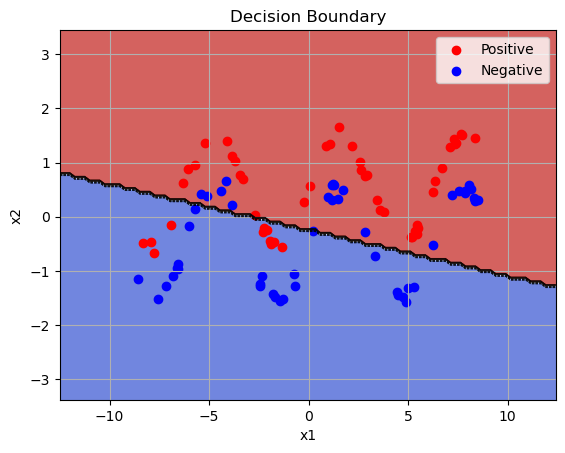

In [22]:
from vis_utils import visualize_2D_border

x1_intervals = (x_train[:, 0].min(), x_train[:, 0].max())
x2_intervals = (x_train[:, 1].min(), x_train[:, 1].max())

# expand 2.0 times
x1_mean = x1_intervals[0] + (x1_intervals[1] - x1_intervals[0]) / 2
x2_mean = x2_intervals[0] + (x2_intervals[1] - x2_intervals[0]) / 2

x1_intervals = (x1_mean - (x1_mean - x1_intervals[0]) * 2.0, x1_mean + (x1_intervals[1] - x1_mean) * 2.0)
x2_intervals = (x2_mean - (x2_mean - x2_intervals[0]) * 2.0, x2_mean + (x2_intervals[1] - x2_mean) * 2.0)

visualize_2D_border(svm, x1_intervals, x2_intervals, x_test, y_test)

接下来，清你自行编写代码，通过调整kernel类型、kernel参数、C值来提高模型的预测准确率。你可以仿照上述代码，来查看不同参数下的分类热力图、分类边界以及测试集数据点。

**请将训练准确率提升到99%以上，将测试集准确率提升到95%以上**

注意：每次修改参数后，需要重新初始化svm, optimizer 并调用optimizer.fit()来进行训练。


0it [00:00, ?it/s]
3it [00:00, 24.53it/s]
6it [00:00, 18.35it/s]
8it [00:00, 18.49it/s]
10it [00:00, 18.21it/s]
12it [00:00, 17.45it/s]
14it [00:00, 17.51it/s]
16it [00:00, 17.70it/s]
19it [00:01, 18.15it/s]
22it [00:01, 20.66it/s]
25it [00:01, 21.54it/s]
28it [00:01, 21.97it/s]
31it [00:01, 22.91it/s]
34it [00:01, 22.58it/s]
37it [00:01, 24.32it/s]
41it [00:01, 26.57it/s]
45it [00:02, 29.66it/s]
49it [00:02, 31.51it/s]
53it [00:02, 32.30it/s]
57it [00:02, 33.38it/s]
62it [00:02, 36.12it/s]
66it [00:02, 36.62it/s]
72it [00:02, 41.43it/s]
78it [00:02, 44.33it/s]
83it [00:02, 45.19it/s]
88it [00:03, 44.56it/s]
93it [00:03, 43.39it/s]
98it [00:03, 42.66it/s]
103it [00:03, 40.96it/s]
108it [00:03, 36.32it/s]
113it [00:03, 37.96it/s]
118it [00:03, 39.09it/s]
124it [00:03, 42.24it/s]
129it [00:04, 43.36it/s]
134it [00:04, 41.39it/s]
140it [00:04, 44.27it/s]
146it [00:04, 47.94it/s]
151it [00:04, 48.06it/s]
157it [00:04, 50.51it/s]
163it [00:04, 52.43it/s]
169it [00:04, 52.76it/s]
175it [00:

2096it [00:33, 91.06it/s]
2106it [00:33, 89.47it/s]
2118it [00:33, 96.35it/s]
2128it [00:33, 96.93it/s]
2139it [00:34, 100.10it/s]
2150it [00:34, 98.91it/s] 
2160it [00:34, 95.05it/s]
2170it [00:34, 95.78it/s]
2181it [00:34, 97.62it/s]
2191it [00:34, 91.98it/s]
2201it [00:34, 87.32it/s]
2210it [00:34, 81.32it/s]
2219it [00:35, 82.49it/s]
2228it [00:35, 84.22it/s]
2245it [00:35, 63.65it/s]


Training finished
prediction accuracy on training set is 100.0.
prediction accuracy on test set is 99.0.



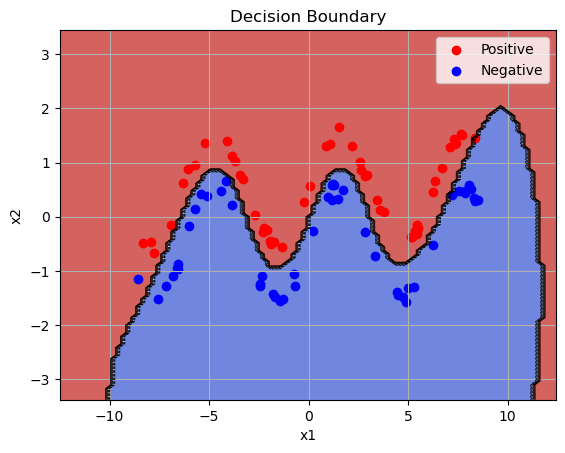

In [23]:
# TODO: Implement the code to improve the accuracy of svm in the training and test set.
from SVM import SVM
from kernels import Linear_kernel, Polynomial_kernel, RBF_kernel
from SSMO import SSMO_optimizer
from vis_utils import visualize_2D_border

def compute_acc(y, y_pred):
    return (np.sum(y == y_pred) / y.shape[0]) * 100

C=2.22
sigma=1.82
 
kernel_fn = RBF_kernel(sigma=sigma)
svm = SVM(kernel_fn=kernel_fn)

max_passes = 114514

optimizer = SSMO_optimizer(C=C)
optimizer.fit(svm, x_train, y_train, max_passes=max_passes, verbose=False)

y_pred_train = svm.predict(x_train)[-1]
train_acc = compute_acc(y_train, y_pred_train)

y_pred_test = svm.predict(x_test)[-1]
test_acc = compute_acc(y_test, y_pred_test)

print(f'prediction accuracy on training set is {train_acc}.')
print(f'prediction accuracy on test set is {test_acc}.\n')

x1_intervals = (x_train[:, 0].min(), x_train[:, 0].max())
x2_intervals = (x_train[:, 1].min(), x_train[:, 1].max())

# expand 2.0 times
x1_mean = x1_intervals[0] + (x1_intervals[1] - x1_intervals[0]) / 2
x2_mean = x2_intervals[0] + (x2_intervals[1] - x2_intervals[0]) / 2

x1_intervals = (x1_mean - (x1_mean - x1_intervals[0]) * 2.0, x1_mean + (x1_intervals[1] - x1_mean) * 2.0)
x2_intervals = (x2_mean - (x2_mean - x2_intervals[0]) * 2.0, x2_mean + (x2_intervals[1] - x2_mean) * 2.0)

visualize_2D_border(svm, x1_intervals, x2_intervals, x_test, y_test)